# 3 Sentiment analysis

For the predictive model I use pretrained bidirectional transformer [BERT](https://huggingface.co/transformers/model_doc/bert.html).

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
from sklearn import metrics


sns.set(font_scale=2)


model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels= 5)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

plt.style.use('seaborn-white')
%matplotlib inline

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The random number seed for shuffling the training set should be used for maintaining shuffling in the case of Python runtime not keeping it's state between epochs (e.g. [Google Colab](https://colab.research.google.com)):

In [110]:
seed_batching = 123

In [111]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  3845      
Total params: 109,486,085
Trainable params: 109,486,085
Non-trainable params: 0
_________________________________________________________________


## 3.1 Creating of Training and Validation sets
The dataset is splitted into train (80% samples) and validation (20%) sets: 

Loading clean and deduplicated dataset (**only first 10000 rows, for actual training remove the limitation**):

In [188]:
#df_dedup = pd.read_csv("./ReviewsDedupLowNT.csv.zip", compression="zip", index_col=0, nrows=10000)
df_dedup = pd.read_csv("./ReviewsDedupLowNT.csv.zip", compression="zip", index_col=0)

In [189]:
df_dedup.tail(5)

,Text,Summary,Score,HelpfulnessNumerator,HelpfulnessDenominator
394998,these are sooooooooooooooooooooooooo delicious...,"yummy. yummy, yummy!",5,0,3
394999,this is a for the price of review because p...,pure chocolate mallomars cookies,4,0,0
395000,this would be a great coffee drink to grab out...,soso espresso style coffee drink,3,1,2
395001,"earths best infant formula soy iron,ounce is a...",earths best soy baby formula,5,0,0
395002,taste. i was expecting it to taste pretty clos...,ehh okay i guess.,2,1,1


In [190]:
df_train = df_dedup.sample(frac=0.8,random_state=123)
df_test = df_dedup.drop(train.index)

In [191]:
def convert_df_to_twocolumn_labeldecrease(input_df, data_col_name, label_col_name):
    out_df = input_df[[data_col_name, label_col_name]]
    out_df = out_df.rename(columns={data_col_name: "DATA_COLUMN", label_col_name: "LABEL_COLUMN"})
    out_df["LABEL_COLUMN"] = out_df["LABEL_COLUMN"] - 1
    return(out_df)

In [192]:
train = convert_df_to_twocolumn_labeldecrease(df_train, "Text", "Score")
test = convert_df_to_twocolumn_labeldecrease(df_test, "Text", "Score")

At the first step a model predicting review score based on the review text will be created.
For training of the BERT model the dataset samples should be converted to the *InputExample* objects, containing

- *guid* - unique id for the example (not used)
- *text_a* (string) - the untokenized text of the first sequence
- *text_b* (optional, string) - the untokenized text of the second sequence (not used)
- label (optional, int) - The label of the example

and assembled to the TensorFlow datasets *train_data* and *validation_data*:

In [113]:
def convert_validation_to_examples(test, DATA_COLUMN, LABEL_COLUMN): 
    validation_InputExamples = test.apply(lambda x: InputExample(guid=None,
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)  
    return validation_InputExamples


def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True, # Add [CLS] and [SEP]
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'DATA_COLUMN'
LABEL_COLUMN = 'LABEL_COLUMN'

In [114]:
validation_InputExamples = convert_validation_to_examples(test, DATA_COLUMN, LABEL_COLUMN)
validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
#validation_data = validation_data.batch(32)

/usr/local/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [36]:
model.load_weights("./amazon_my_trained_FL_G_k7e12ac78L03vac75VL04g2lr4")

## 3.2 Model analysis
The model confusion matrix for the 500 samples validation subset is following: 

In [264]:
def batch_tokenize_predict(data_column):
    tf_batch = tokenizer(data_column, max_length=128, padding=True, truncation=True, return_tensors='tf')
    tf_outputs = model(tf_batch)
    predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
    max_predictions = np.argmax(predictions, axis=1)
    return(max_predictions)

In [265]:
batch_length = 500

text_predictions = batch_tokenize_predict(test["DATA_COLUMN"].tolist()[0:batch_length])
y_test = test["LABEL_COLUMN"][0:batch_length]               
confusion_matrix = metrics.confusion_matrix(y_test, text_predictions)

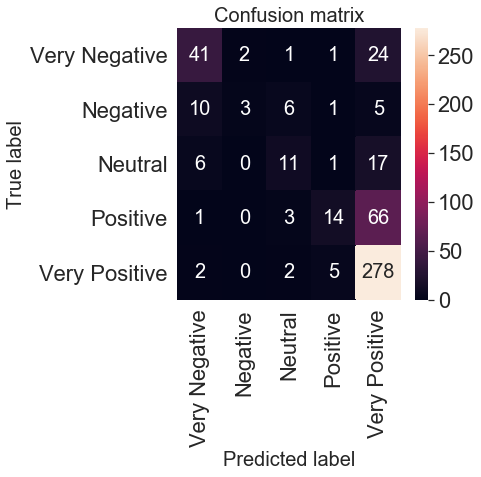

accuracy for 500-element validation subset is 0.694.


In [266]:
plt.figure(figsize=(5, 5))
LABELS = ['Very Negative','Negative','Neutral','Positive','Very Positive']
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

values = confusion_matrix.view()
error_count = values.sum() - np.trace(values)
accuracy = 1.0 - error_count/batch_length
print("accuracy for {0}-element validation subset is {1}.".format(batch_length, accuracy))

One can see, that mostly neighboring scored elements are misclassified.
However a substantial number of *Very Negative* samples were missclassified as *Very Positive*.
Let's take a look at such samples:

In [219]:
bad_as_good = test["DATA_COLUMN"][0:text_predictions.size].loc[
    (text_predictions==4)&(test["LABEL_COLUMN"][0:text_predictions.size]==0)].tolist()

In [220]:
print(BadAsGood[0])

all good things must come to an end and the end of the great season sardines is now.  previous years season sardines were too good.  season manischewitz co. no longer gets these sardines from norway.  now they supply low grade sardines from scotland canners.  last year, these were the best northern sardines available now they are inedible.  amazons web page is in error . . . the package now says product of scotland.they also switched to a much lower grade oil, pure instead of extra virgin.  it doesnt even taste like olive oil.  the fish have a poor texture and worse flavor.  i couldnt finish one can.  other sardine brands have switched from norwegian to scottish suppliers to reduce cost before.  these are among the lowest quality commodity sardines available.  anything in your local store has better flavor and texture.  these season sardines are rubbery and seem underdone.please understand im not just saying these are not up to their previous high standard.  im saying these season sard

In [221]:
print(bad_as_good[1])

free glutamic acid in high concentration is neurotoxic. free glutamates have many many aliases msg is only one. these organic better than bouillon products simply dont have the monosodium variety of glutamic acid, so they can say no msg. its labeling trickery. the ultimate labeling question. what is natural flavor?


In [222]:
print(bad_as_good[2])

my family have been gluten free for  years now. i also work in the natural products industry at the senior level and have seen the deception first hand. gluten is quite a serious issue as when it is consumed the villi are inpaired and other nutrients needed to be assimilated for other necessary body functions are not absorbed. it has caused my family other serious complications from eyesight to teeth and mouth difficulties and it has to stop. i am writing this reveiw because i am tired of feeling powerless while companies are prospering at the expense of our health. i follow a paleolithic diet for the most part and recently for my birthday decided to have a turkey sandwich on udis bagels. well they are most certainly not gluten free. even if less than ppm still makes someone sick. my entire mouth broke out in canker sores and i got a white spot on my front tooth that has not gone away because the gluten sensitivity is preventing iron absorption. udis is making millions of dollars and p

In [199]:
print(bad_as_good[3])

 shipping? per each?  sell these by the case and i would have tried it.  ridiculous price.


It looks like the model learned very expressive reviews as very positive. Another source of errors could be very long reviews containing many points with different sentiment.  

## 3.3 Sentiment correlation between review summary and text 

In [204]:
summary_test = convert_df_to_twocolumn_labeldecrease(df_test, "Summary", "Score")

In [205]:
summary_test.tail()

,DATA_COLUMN,LABEL_COLUMN
394984,yummy,4
394990,yummy,4
394992,great tasting,4
394994,caffeen addicts need not apply,0
395000,soso espresso style coffee drink,2


In [267]:
sum_predictions = batch_tokenize_predict(summary_test["DATA_COLUMN"].tolist()[0:batch_length])
confusion_matrix_sumvstext = metrics.confusion_matrix(text_predictions, sum_predictions)

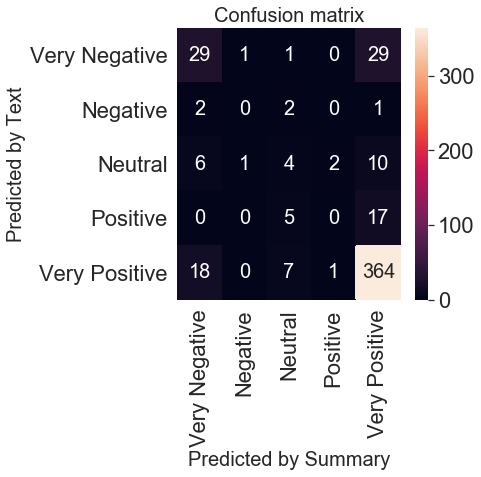

accuracy for 500-element validation subset is 0.794.


In [268]:
plt.figure(figsize=(5, 5))
LABELS = ['Very Negative','Negative','Neutral','Positive','Very Positive']
sns.heatmap(confusion_matrix_sumvstext, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('Predicted by Text', fontsize=20)
plt.xlabel('Predicted by Summary', fontsize=20)
plt.show()

values = confusion_matrix_sumvstext.view()
error_count = values.sum() - np.trace(values)
accuracy = 1.0 - error_count/batch_length
print("accuracy for {0}-element validation subset is {1}.".format(batch_length, accuracy))

The sentiment of Summary and Text is generally aligned. Let's inspect the cases the samples with extreme missalignment:    

In [258]:
badtext_goodsum = df_test[["Text", "Summary", "Score"]][0:text_predictions.size].loc[
    (text_predictions==0)&(sum_predictions==4)]
goodtext_badsum = df_test[["Text", "Summary", "Score"]][0:text_predictions.size].loc[
    (text_predictions==4)&(sum_predictions==0)]

In [261]:
def print_text_sum_pred(text_pred, sum_pred, index):
    df_cmp = df_test[["Text", "Summary", "Score"]][0:text_predictions.size].loc[
    (text_predictions==text_pred)&(sum_predictions==sum_pred)]
    print(df_cmp.iloc[[index]]["Text"].tolist(), 
          df_cmp.iloc[[index]]["Summary"].tolist(), 
          df_cmp.iloc[[index]]["Score"])

In [260]:
print_text_sum_pred(0, 4, 2)

['someone gave me a senseo machine, so i bought this coffee.  im very disappointed with the taste!  its bland and dull tasting.  too bad, as i have  bags now!this was my previous review.  since then, i gave away the senseo machine, but i kept the coffee and use it in a cup of hot water i do in the microwave.  the coffee is actually good.  i guess somehow the machine flavored it.  maybe its because the water doesnt sit in the coffee for long enough.  using my microwave method, i let the coffee bag brew awhile before pressing it and removing it  very good taste.  go figure!  anyway, id recommend this coffee as microwavable bags.'] ['disappointed, then happy'] 286    4
Name: Score, dtype: int64


In [262]:
print_text_sum_pred(0, 4, 4)

['you expect me to eat this slog? jerry slammed down his sandwich, which, in his meaty claws, had been pressed into a mound of bread shards and ham chunks. he picked a leaf of lettuce from the shrapnel that was once, only a few moments ago, a wellmade sandwich, one created out of love. and whatd i tell you about lettuce? i dont want to see this on any more of my sandwiches! he took off his glasses and wiped his brow, falling back onto the stool at the kitchen counter.i dont know for how long i stood there, my mouth agape, my fingers clenched around the tupperware bowl of sliced ham, my knees shaking. id never seen my son so angry.he opened his coloring book and searched his crayon box for the right color. just once he said, feverishly putting a green crayon to work on a page, id like a sandwich that isnt so. so stinking plain. he glared at me a moment before searching for a new color.i was frozen. i had failed, again, to find a satisfactory sandwich for my son. as i returned the tub of

In [263]:
print_text_sum_pred(4, 0, 2)

['  why would anyone pay this price?  it costs about  dollars in the grocery store.  i dont get it.'] ['why would anyone pay this price?'] 425    1
Name: Score, dtype: int64


In [269]:
print_text_sum_pred(4, 0, 4)

[' a bottle, they must be kidding!you can get this for. to. at anyconvenience store and they are hardly knownfor low prices.you would have to be brain damaged to paythese prices!'] ['mega ripoff!'] 471    1
Name: Score, dtype: int64


The examples above shows that Summary and Text missalignment appears usually if one of the fields (Text or Summary) is very hard to classify due to lack of useful tokens in very short summary or excessive size of the review Text, containing sentences with various sentiment.